# Final Download Model - Elastic Net Robust Scaler No Outliers

--- 

In this notebook we put together all relevant notebooks to make our predicitions based on our recomendations.

We recommend an Elastic Net model with Robust Scaler and outlier removal for the download data set; model has little complexity and marginal performance loss versus a Random Forrest Regressor model (0.2% - 2%). Performance is based on RMSE; complexity in Fit and Score Time.

# Import Libraries and Set Options

---

## General Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from datetime import datetime

# Data Preparation

---

## Read in Data and Instantiate DataFrame 
We read in the feature description and the raw download data. The DataFrame 'df' will be transformed in this Section. The DataFrame 'df_raw' will remained unchanged and serves as a reference throughout the Notebook. 

In [2]:
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #

df = pd.read_csv('./data/Data_down.csv', delim_whitespace=True)
df_raw = pd.read_csv('./data/Data_down.csv', delim_whitespace=True)

# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #
# --> READ IN YOUR DATA HERE! INSTANTIATE BOTH FRAMES! <-- #

In [3]:
# df.head()

In [4]:
# df.columns

In [5]:
# len(df)

## Drop Features Without Information 

Drop features with no (usable) information.

In [6]:
for column in df: 
    if len(df[column].unique()) < 2:
        print(f"Feature '{column}' contains no information!")
        df = df.drop(column,axis=1)
        print("-> Feature was dropped from the DataFrame")

Feature 'connected' contains no information!
-> Feature was dropped from the DataFrame


In [7]:
# df.head()

# Visualize Label Data

---

In [8]:
# df.info()

In [9]:
# df.describe()['throughput']

In [10]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='throughput',kde=True);
# note that the distribution is not normal (it resembles a exponential / Poisson distribution, which is a plaussible assumption for a communication model). Mass of the curve is shifted to the left. 

In [11]:
# plt.figure(figsize=(16,10))
# sns.boxplot(data=df, x='throughput');

# note some outliers by the IQR method 

# Explore Correlation Heatmap
---

## Initiate Correlation Heatmap

In [12]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);

**Heatmap Finding**

**High Positive Correlation**
- id and timestamp
- measuremet and rawTimesamp
- rsrp and ss (signal strength) 

**Positive Correlation**
- pci and lon

**Negative Correlation**
- speed and lat

**High Negative Correlation**
- alt and lat

**Label**

Throughput shows non-zero correlations with features -> some signal will be picked by the model / no zero importance features

**Heatmap Finding Conclusion**

- Drop **id** and **measurement**: (a) both enconded in other features (b) irrelevant for our predictions (watch out for systematic errors in the experiment phase!) 

- For the reason delineated in (b) we also drop **pci** (physical cell id) (watch out for systematic errors in the experiment phase!) 

- Drop **ss**: calculated based off rsrp / linear transformation of rsrp -> will lead to decreased generalization performance of ML models

## Drop Features based on Heatmap Finding

In [13]:
df = df.drop('id',axis=1)
df = df.drop('measurement', axis=1)
df = df.drop('pci',axis=1)
df = df.drop('ss',axis=1)

# alt and lat are highly correlated! 

In [14]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);

# Check for Missing Data
---

In [15]:
def percent_missing(df): 
    percent_nan = df.isnull().sum() / len(df) * 100
    percent_nan = percent_nan[percent_nan>0].sort_values()
    
    return percent_nan

In [16]:
percent_missing(df).sum()
# no misiing data

0.0

In [17]:
# Plot percentage of missing data as bar graph (no missing data in this case)

# percent_nan = percent_missing(df)
# 
# plt.figure(figsize=(10,8))
# sns.barplot(x=percent_nan.index,y=percent_nan)
# plt.xticks(rotation=90);

# Further Feature Exploration and Selection 
---

## Datetime

In [18]:
# df_raw.columns

### timestamp Feature

In [19]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='rawTimesamp',y='timestamp');
# timestamp seems to be an arbitrary value assigned on the datapoint depending on the particular experiment (measurement). 

In [20]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='measurement',y='timestamp');

In [21]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, y='id',x='timestamp');

# note also the timestamp encondes id / higly correlated to id (as noted in the heatmap). We drop timestamp for the following reasons: (a) our predictions should be independent of vehicle / measurement id, (b) rawTimesamp functions as a datetime object for the data frame, and (c) we don't have enough context to interpret id

In [22]:
df = df.drop('timestamp', axis=1)

In [23]:
# we also rename rawTimesamp to better describe the feature
df = df.rename(columns={'rawTimesamp':'unix_time'})

In [24]:
# we rename location to better describe the feature
df = df.rename(columns={'location':'region'})

In [25]:
# df.info()

**Features**
1. unix time
2. distance
3. location
    - latitude
    - longitude
    - altitude
4. mobility / motion
    - speed
    - acceleration
    - direction
5. LTE performance
    - rsrp
    - rsrq
    - sinr
    - cqi (categorical?)
    - ta (categorical?)
6. ci (categorical!)
7. payload
8. rtt
9. location -> region (categorical!)

### unix_time Feature

We break down Unix time into more useful (categorical) features. 

In [26]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='unix_time',y='throughput');

In [27]:
# plt.figure(figsize=(16,16),dpi=200)
# sns.scatterplot(data=df_raw, x='lon',y='lat',hue='rawTimesamp',palette='magma');

In [28]:
datetime_series = df['unix_time'].apply(lambda unix_time : datetime.fromtimestamp(unix_time))

In [29]:
datetime_series

0      2018-12-10 10:08:57
1      2018-12-10 10:09:09
2      2018-12-10 10:09:19
3      2018-12-10 10:09:33
4      2018-12-10 10:09:42
               ...        
2136   2019-01-18 10:22:10
2137   2019-01-18 10:22:23
2138   2019-01-18 10:22:30
2139   2019-01-18 10:22:41
2140   2019-01-18 10:22:49
Name: unix_time, Length: 2141, dtype: datetime64[ns]

In [30]:
datetime_series.apply(lambda dt : dt.year).unique()
# not enough data -> disregard

array([2018, 2019])

In [31]:
datetime_series.apply(lambda dt : dt.month).unique()
# not enough data -> disregard

array([12,  1])

In [32]:
datetime_series.apply(lambda dt : dt.hour).unique()
# might be interesting to engineer the features morning and afternoon -> dive deeper

array([10,  9,  6, 14, 15, 12, 13])

In [33]:
hour_arr = datetime_series.apply(lambda dt : dt.hour)

In [34]:
hour_df = pd.DataFrame(hour_arr)

In [35]:
hour_df = hour_df.rename({'unix_time':'hour'},axis=1)

In [36]:
hour_df.value_counts()
# distributed fairly evenly -> make categories morning (5 < t_0 < 11) and afternoon (11 < t_0 < 16), i.e. a binary categorical feature

hour
6       640
14      505
10      309
13      297
15      274
9       114
12        2
dtype: int64

In [37]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=hour_arr,y=df['throughput'])
# ax.set_xlabel('Hour');

In [38]:
# Originally we wanted to create categories based on different hour intervalls. This idea was scrapped. 

# def time_of_day(h): 
#     if h < 9: 
#         return 'early morning'
#     elif 9 <= h < 12: 
#         return 'morning'
#     elif 12 <= h < 14: 
#         return 'noon'
#     else: 
#         return 'evening'

In [39]:
# hour_df['hour'] = hour_df['hour'].apply(time_of_day)

In [40]:
# hour_df = hour_df.rename({'hour':'time'},axis=1)

In [41]:
# hour_df.value_counts()

In [42]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=hour_df['time'],y=df['throughput'])
# ax.set_xlabel('Time');

---

In [43]:
datetime_series.apply(lambda dt : dt.day_name()).unique()
# all days of the week -> dive deeper; we enconde the weekdays as integers

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'],
      dtype=object)

In [44]:
weekday_arr = datetime_series.apply(lambda dt : dt.day_name())

In [45]:
weekday_df = pd.DataFrame(weekday_arr)

In [46]:
weekday_df = weekday_df.rename({'unix_time':'weekday'},axis=1)

In [47]:
weekday_df.value_counts()
# make categorical feature weekday

weekday  
Tuesday      563
Thursday     493
Wednesday    462
Monday       324
Friday       299
dtype: int64

In [48]:
# plt.figure(figsize=(16,10))
# ax = sns.scatterplot(x=weekday_arr,y=df['throughput'],hue=hour_df['hour'],palette='magma')
# ax.set_xlabel('Weekday');
# note that on Friday we mostly find data in the morning hours, on Monday and Wednesday mostly in the evening and on Tuesday and Thrusday around midday -> suggestion for experiment phase: take data throughout the day for all days

In [49]:
# add new features to df and drop unix_time: 
df['hour'] = hour_df['hour']
df['weekday'] = weekday_df['weekday']
df = df.drop('unix_time',axis=1)

In [50]:
# df.info()

## Distance

In [51]:
df['distance'].describe()

count     2141.000000
mean      4273.932844
std       3774.430086
min         99.420000
25%       1365.830000
50%       2825.780000
75%       6435.790000
max      14124.020000
Name: distance, dtype: float64

## Mobility Context

### Position: Latitude, Longitude, and Altitude / Elevation

Note the small scale of the values -> normalization / standardization necessary!

In [52]:
df[['lat','lon','alt']].describe().transpose().drop('count',axis=1)
# standardize features!  

,mean,std,min,25%,50%,75%,max
lat,51.478644,0.022528,51.437142,51.463083,51.481652,51.490668,51.517905
lon,7.445595,0.030796,7.393019,7.416637,7.450149,7.473018,7.491755
alt,177.235390,41.975692,125.060000,152.000000,163.700000,181.920000,297.820000


### Motion: Speed, Acceleration, and Direction

The ML Paper mentions trajectory of the vehicle as well (engineered featured; see ML Paper). The feature direction seems to be encoded in the feature trajectory in the paper. The feature acceleration is not mentioned in the paper. We explore this feature. 

In [53]:
df[['speed','acc','dir']].describe().transpose().drop('count',axis=1)
# stardardize features!

,mean,std,min,25%,50%,75%,max
speed,12.154703,8.870322,0.00,6.86,12.45,14.99,39.34
acc,0.004447,1.123975,-11.05,0.00,0.00,0.00,17.26
dir,164.828720,93.178596,0.03,92.30,150.27,250.64,359.98


In [54]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='acc',bins=100)

In [55]:
acc = df['acc']

outliers = acc[(acc < -(3*acc.std())) | (acc > 3*acc.std())]
len(outliers)

# outliers are 3 STD aways from the mean

32

In [56]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set (3 std away from the mean)'

'Outliers are 1.49% of the Download data set (3 std away from the mean)'

In [57]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='acc',y='throughput')

In [58]:
# at this points we have two options: (a) drop the outliers or (b) drop the feature entirely. Unfortunately, we do not have enough context or knowledge to make an appropiate decision. Thus we might pursue both options. 

df = df[(df['acc'] > -3) & (df['acc'] < 3)]

In [59]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='acc',bins=100)

In [60]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='acc',y='throughput')

### Cell ID

There is not enough context provided in the feature description. We assume CI represents Cell Id. In the Paper Cell Id is assigned to the Mobility Context. We assume CI is a categorical feature. Read more [here](https://en.wikipedia.org/wiki/GSM_Cell_ID). 

In [61]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ci',y='throughput')
# note that certain CIs have a narrower distribution that others. 

## Network Context / Channel Performance: RSRP, RSRQ, SINR, CQI, TA

The studies agree that passively measurable network quality indicators such as Reference Signal Received Power (RSRP), Reference Signal Received Quality (RSRQ), Signal- to-interference-plus-noise Ratio (SINR), and Channel Quality Indicator (CQI) provide meaningful information, which can be leveraged to estimate the resulting data rate based on machine learning methods even in challenging environments. We also consider Timing Advance (TA). 

In [62]:
df[['rsrp', 'rsrq','sinr', 'cqi', 'ta']].describe().transpose().drop('count',axis=1)

,mean,std,min,25%,50%,75%,max
rsrp,-88.546927,9.286616,-113.0,-95.0,-89.0,-83.0,-56.0
rsrq,-7.465936,2.085438,-19.0,-9.0,-7.0,-6.0,-4.0
sinr,13.432111,9.748337,-15.0,6.0,12.0,21.0,40.0
cqi,9.920915,3.325156,1.0,7.0,10.0,12.0,15.0
ta,7.039066,6.167537,0.0,3.0,6.0,9.0,94.0


In [63]:
df['ta'].describe()
# extreme outliers in the data -> consider droping some datapoints

count    2099.000000
mean        7.039066
std         6.167537
min         0.000000
25%         3.000000
50%         6.000000
75%         9.000000
max        94.000000
Name: ta, dtype: float64

In [64]:
ta = df['ta']

q75, q25 = np.percentile(a=ta, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [65]:
up_lim
# this threshold might be too agressive. 

18.0

In [66]:
outliers = ta[(ta < low_lim) | (ta > 30)]
len(outliers)

12

In [67]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set according to the IQR Method'

'Outliers are 0.57% of the Download data set according to the IQR Method'

In [68]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='ta',kde=True)

In [69]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ta',y='throughput')
# dropping after 18 might be too aggresive. We an arbitrary threshold at 30. 

In [70]:
# plt.figure(figsize=(16,10))
# df_ta = df[df['ta'] < 30]
# sns.histplot(data=df_ta, x='ta',bins=100)

In [71]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df, x='ta',y='throughput')

In [72]:
df = df[(df['ta'] > low_lim) & (df['ta'] < 30)]

In [73]:
len(df)

2087

## Application Context: Payload

In [74]:
df['payload'].describe()

count    2087.000000
mean        4.526737
std         3.228119
min         0.100000
25%         1.000000
50%         4.000000
75%         7.000000
max        10.000000
Name: payload, dtype: float64

## Additional Features not found in the Paper

The Round Trip Time (RTT) and the Location (Region) are not mentioned as Features in the Paper but we'll consider them for our analyis. We explore RTT in this Section. 

In [75]:
df['rtt'].describe()
# extreme outliers in the data -> consider droping some datapoints

count    2087.000000
mean       70.320077
std       164.159120
min        29.000000
25%        37.000000
50%        46.000000
75%        71.000000
max      5323.000000
Name: rtt, dtype: float64

In [76]:
rtt = df['rtt']

q75, q25 = np.percentile(a=rtt, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [77]:
up_lim

122.0

In [78]:
outliers = rtt[(rtt < low_lim) | (rtt > up_lim)]
len(outliers)

88

In [79]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data set according to the IQR Method'

'Outliers are 4.22% of the Download data set according to the IQR Method'

In [80]:
# plt.figure(figsize=(16,10))
# sns.histplot(data=df, x='rtt',kde=True)

In [81]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_raw, x='rtt',y='throughput')

In [82]:
# plt.figure(figsize=(16,10))
# df_rtt = df[df['rtt'] < up_lim]
# sns.histplot(data=df_rtt, x='rtt',bins=40)

In [83]:
# plt.figure(figsize=(16,10))
# sns.scatterplot(data=df_rtt, x='rtt',y='throughput')

In [84]:
# at this points we have two options: (a) drop the outliers or (b) drop the feature entirely. Unfortunately, we do not have enough context or knowledge to make an appropiate decision. Thus we might pursue both options. 
df = df[df['rtt'] < up_lim]

# Further Considerations: Location
---

## Investigate Correlation between Altitude and Latitude

In [85]:
# plt.figure(figsize=(16,14))
# sns.heatmap(df.corr(),cmap='magma',annot=True);
# note the high negative correlation between altitude and latitude

In [86]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='alt');

# note that this high negative correlation could introduce systematic errors to our model -> suggestion in experiment phase: more variety of latitude, altitude tuples

In [87]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='alt',y='lat',hue='rsrp',palette='magma');

# we see the high negative correlation between the features, but no particular pattern when considering the rsrp

In [88]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='alt',y='lat',hue='throughput',palette='magma');

# we see the high negative correlation between the features, but no particular pattern when considering the throughput -> we won't drop either of the features

In [89]:
# we can visualize the rsrp in a 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# 
# fig = plt.figure(figsize=(16,10))
# ax = Axes3D(fig)
# 
# x = df['lat']
# y = df['lon']
# z = df['alt']
# c = df['rsrp']
# 
# sc = ax.scatter(x,y,z,s=40,c=c,cmap='magma',alpha=.5)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')
# ax.set_zlabel('Altitude')
# 
# plt.legend(*sc.legend_elements(), loc='best');

# plt.savefig("scatter_hue", bbox_inches='tight')

In [90]:
# we can visualize the throuhput in a 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# 
# fig = plt.figure(figsize=(16,10))
# ax = Axes3D(fig)
# 
# x = df['lat']
# y = df['lon']
# z = df['alt']
# c = df['throughput']
# 
# sc = ax.scatter(x,y,z,s=40,c=c,cmap='magma',alpha=.5)
# ax.set_xlabel('Latitude')
# ax.set_ylabel('Longitude')
# ax.set_zlabel('Altitude')
# 
# plt.legend(*sc.legend_elements(), loc='best');

# plt.savefig("scatter_hue", bbox_inches='tight')

## Drop Data Points outside Street
We drop data points outside the street. These points are most likely measurement errors. We export the data to [Google Maps](https://www.google.com/maps/d/edit?mid=16uGNwcuE2fgafLTK6ZG4MUEpYxuT1L7w&usp=sharing) and impute invalid data points. Note that Google Maps can take max. 2000 data points. An alternative to this method is plotly (JavaScript configuration required). 

<img src="./figures/gmaps.png" width="600" alt="Architecture model for the client-based data rate prediction." class="center">

In [91]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='region');

In [92]:
# Using Google Maps

# df[['lon','lat','region']].to_csv('./data/dl-loc.csv', index=False)

# Afterwards convert Google Map to .CSV with https://www.gpsvisualizer.com/convert_input and download the .CSV file
# read in file and inner join with df on longitude and latitude

In [93]:
# import plotly.express as px
# 
# fig = px.scatter(data_frame=df, x='lon',y='lat',hover_name=df.index)
# fig.show()
# 
# # we drop rows with the following index: 1906,1908,1902,1962 and 780, 1695, 1369, 566, 629,1549,1436

In [94]:
# drop location that do not exist in the urban region
# df = df.drop([1906,1908,1902,1962])

In [95]:
# drop location that do not exist in the rest of the regions
# df = df.drop([780, 1695, 1369, 566, 629,1549,1436])

In [96]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='lon',y='lat',hue='region');

In [97]:
# df.info()

# Check for Outliers

## IQR Methodology

In [98]:
label = df['throughput']

In [99]:
q75, q25 = np.percentile(a=label, q=[75,25])
IQR = q75 - q25

low_lim = q25-1.5*IQR
up_lim = q75+1.5*IQR

In [100]:
outliers = label[(label < low_lim) | (label > up_lim)]
len(outliers)

# there are 19 outlierts in the data set by IQR method 

19

In [101]:
f'Outliers are {len(outliers)/len(df)*100:.2f}% of the Download data according to the IQR Method'

'Outliers are 0.95% of the Download data according to the IQR Method'

In [102]:
# since the number is low we might consider dropping the these rows; note that the distribution of the throughput is not normal -> dive deeper to determine true outliers

## Check Feature Correlations with Label & Decide what constitutes an Outlier

In [103]:
df.corr()['throughput'].sort_values(ascending=False)
# note that payload is highly positively correlated to download throughput (it also makes sense that a higher payload produces a high throughput)

throughput    1.000000
payload       0.684078
rsrp          0.286182
rsrq          0.275477
sinr          0.252092
cqi           0.209498
distance      0.126083
alt           0.051961
speed         0.040815
acc           0.018016
lat           0.005080
dir          -0.030099
ci           -0.034144
lon          -0.037398
hour         -0.108033
ta           -0.165833
rtt          -0.192033
Name: throughput, dtype: float64

In [104]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='payload', y='throughput',hue='rsrp',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

# note that within every payload size we have a distribution and as payload increses, so does the throughput but also the variane of the distribution within the payload -> not all data points above the upper limit are outliers per se 

In [105]:
np.sort(df['payload'].unique())
# precision of the payload column / x axis 

array([ 0.1,  0.5,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. ,
       10. ])

In [106]:
df.groupby('payload')['throughput'].std().sort_values()
# after droping the outliers we want to keep this relationship between the std's by payload

payload
0.5     2.863273
0.1     3.281618
1.0     3.670574
2.0     4.223012
3.0     4.598494
4.0     4.722336
5.0     4.991452
6.0     5.714600
7.0     5.947428
8.0     6.184221
9.0     6.634810
10.0    7.564087
Name: throughput, dtype: float64

In [107]:
df.groupby('payload')['throughput'].describe().transpose()

payload,0.1,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
count,177.000000,155.000000,180.000000,159.000000,175.000000,175.000000,181.000000,173.000000,155.000000,162.000000,147.00000,157.000000
mean,5.361158,6.929305,7.887633,9.773422,11.462117,13.578815,14.777934,16.531106,17.790126,18.276707,19.93746,20.303460
std,3.281618,2.863273,3.670574,4.223012,4.598494,4.722336,4.991452,5.714600,5.947428,6.184221,6.63481,7.564087
min,0.070194,0.841220,0.472283,1.808110,2.603320,1.431320,2.960990,5.166290,4.543610,1.371100,5.08008,2.672640
25%,4.188500,4.742185,5.642748,6.932440,7.831645,10.288200,11.302600,12.124300,13.442150,14.128850,15.15505,14.773800
50%,4.848500,7.130120,7.533020,9.592330,11.633500,14.375600,14.508500,16.597500,17.891400,18.524000,20.13420,20.010000
75%,5.839440,8.620730,9.635680,12.599350,14.190100,16.675450,18.050500,20.058500,21.764550,22.533225,23.88070,24.922100
max,38.095400,15.625000,21.108200,25.518300,25.000000,26.337400,38.167900,33.826600,38.147100,38.392300,43.01080,41.775500


In [108]:
# we remove the outliers with the same method delineated above
# fig = px.scatter(data_frame=df, x='payload',y='throughput',hover_name=df.index)
# fig.show()
# 
# we drop rows with the following index: 1111, 1835, 871, 569, 1011

In [109]:
# remove outliers left of the mean
# df = df.drop([646])

In [110]:
# remove outliert right of the mean
# df = df.drop([1111, 1835, 871, 569,612,1011,507,338])

In [111]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='payload', y='throughput',hue='rsrp',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

In [112]:
df.groupby('payload')['throughput'].std().sort_values()

payload
0.5     2.863273
0.1     3.281618
1.0     3.670574
2.0     4.223012
3.0     4.598494
4.0     4.722336
5.0     4.991452
6.0     5.714600
7.0     5.947428
8.0     6.184221
9.0     6.634810
10.0    7.564087
Name: throughput, dtype: float64

**Comment**: we use a visualization and our (qualitative) judgement to remove outliers. Note that an alternative to this would be an algorithm that (a) groups the data points by payload and (b) removes the outliers per payload by considering an IQR or STD method. Since we have to do the outlier removal operation only once, we won't automate this process

---

In [113]:
# plt.figure(figsize=(16,16))
# sns.scatterplot(data=df, x='rsrp', y='throughput',hue='payload',palette='magma')
# 
# plt.axhline(y=up_lim,color='orange',alpha=.5,label='q75 + 1.5 IQR')
# 
# plt.legend(loc=(1.02,.5));

In [114]:
# df.head()

In [115]:
# df.info()

In [116]:
# df.to_csv('./data/d-no-ns-nd.csv', index=False)
# pfe = post feature engineering
# ns = not scaled
# nd = no dummy variables

# Encoding Categorical Features

We create dummy variables for the following features: 
- region 
- weekday
- ci (we don't have enough domain knowledge to check if this is a correct assumption)

The following ordinal features remain unchanged (not enough domain knowledge, but by reading the articles we can infer there is an order to the variable values).
- [CQI](https://ytd2525.wordpress.com/2014/02/02/cqi-channel-quality-indicator/)

In [117]:
cat_features = ['ci','region','weekday']
cat_df = df[cat_features].copy()

In [118]:
# convert CI int -> object
cat_df['ci'] = cat_df['ci'].apply(str)

In [119]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 0 to 2140
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ci       1996 non-null   object
 1   region   1996 non-null   object
 2   weekday  1996 non-null   object
dtypes: object(3)
memory usage: 62.4+ KB


In [120]:
non_cat_df = df.drop(cat_features, axis=1)

In [121]:
non_cat_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,cqi,ta,payload,throughput,rtt,hour
0,99.42,51.490553,7.413966,157.63,11.83,0.00,79.35,-85,-5,22,10,7,0.1,6.83763,41,10
1,237.43,51.490715,7.416002,152.41,10.76,-0.52,89.45,-84,-6,11,13,4,2.0,9.71463,58,10
2,325.26,51.490668,7.417176,154.64,6.19,-0.62,27.05,-82,-6,21,15,4,2.0,7.30594,57,10
4,540.48,51.492531,7.416222,154.41,12.33,0.01,336.68,-90,-6,16,9,4,5.0,8.54884,59,10
5,673.04,51.493715,7.415771,152.68,11.88,0.09,347.54,-101,-10,13,15,4,8.0,11.29940,51,10


In [122]:
cat_df_d = pd.get_dummies(cat_df, drop_first=True)
# d = dummy variables, we drop the first column of each set of dummy variables

In [123]:
cat_df_d

,ci_26378497,ci_26378498,ci_26378754,ci_26378755,ci_26379013,ci_26385408,ci_26385409,ci_26385410,ci_26796290,ci_26796291,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [124]:
pfe_df = pd.concat([non_cat_df, cat_df_d],axis=1)
# pfe = post feature engineering

In [125]:
pfe_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,99.42,51.490553,7.413966,157.63,11.83,0.00,79.35,-85,-5,22,...,0,0,0,0,0,0,1,0,0,0
1,237.43,51.490715,7.416002,152.41,10.76,-0.52,89.45,-84,-6,11,...,0,0,0,0,0,0,1,0,0,0
2,325.26,51.490668,7.417176,154.64,6.19,-0.62,27.05,-82,-6,21,...,0,0,0,0,0,0,1,0,0,0
4,540.48,51.492531,7.416222,154.41,12.33,0.01,336.68,-90,-6,16,...,0,0,0,0,0,0,1,0,0,0
5,673.04,51.493715,7.415771,152.68,11.88,0.09,347.54,-101,-10,13,...,0,0,0,0,0,0,1,0,0,0


In [126]:
pfe_df.corr()['throughput'].sort_values()

rtt               -0.192033
ta                -0.165833
region_suburban   -0.109712
hour              -0.108033
ci_28368386       -0.100383
                     ...   
sinr               0.252092
rsrq               0.275477
rsrp               0.286182
payload            0.684078
throughput         1.000000
Name: throughput, Length: 81, dtype: float64

In [127]:
# pfe_df.info()

In [128]:
# originally we were going to move the label to the end of the data frame but we decided against it
# cols = list(df.columns)
# cols.pop(cols.index('throughput'))
# 
# df = df[cols+['throughput']]

In [129]:
pfe_df.head()

,distance,lat,lon,alt,speed,acc,dir,rsrp,rsrq,sinr,...,ci_33527559,ci_33527561,ci_33837570,region_highway,region_suburban,region_urban,weekday_Monday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,99.42,51.490553,7.413966,157.63,11.83,0.00,79.35,-85,-5,22,...,0,0,0,0,0,0,1,0,0,0
1,237.43,51.490715,7.416002,152.41,10.76,-0.52,89.45,-84,-6,11,...,0,0,0,0,0,0,1,0,0,0
2,325.26,51.490668,7.417176,154.64,6.19,-0.62,27.05,-82,-6,21,...,0,0,0,0,0,0,1,0,0,0
4,540.48,51.492531,7.416222,154.41,12.33,0.01,336.68,-90,-6,16,...,0,0,0,0,0,0,1,0,0,0
5,673.04,51.493715,7.415771,152.68,11.88,0.09,347.54,-101,-10,13,...,0,0,0,0,0,0,1,0,0,0


In [130]:
pfe_df.shape

(1996, 81)

# Export Final DataFrame

In [131]:
# pfe_df.to_csv('./data/d-no-ns.csv', index=False)
# pfe = post feature engineering
# ns = not scaled

In [132]:
f'We dropped {(1-(len(pfe_df)/len(df_raw)))*100:.2f}% of the data points in this Section'

'We dropped 6.77% of the data points in this Section'

---
---
---

# Elastic Net Robust Scaler No Outliers

---

In [133]:
# MODIFY! 
# use Robust! 
model_name = 'ela-net-rb-no'

# Import Libraries & Data 

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [135]:
df = pfe_df
X = df.drop('throughput',axis=1)
y = df['throughput']

---

# Scale Data

In [136]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler()

In [137]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Determine Hyperparameters

In [138]:
# MODIFY!
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(l1_ratio=[.1, .5, .7,.8,.9, .95, .99, 1],max_iter=1000000,cv=10)
model

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [139]:
model.fit(X_train, y_train)

ElasticNetCV(cv=10, l1_ratio=[0.1, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
             max_iter=1000000)

In [140]:
model.l1_ratio_

0.7

In [141]:
model.alpha_

0.003969539082438035

In [142]:
hp = pd.Series(name=f'{model_name} HP', data=[model.l1_ratio_, model.alpha_],index=['l1_ratio','alpha'])

In [143]:
hp

l1_ratio    0.70000
alpha       0.00397
Name: ela-net-rb-no HP, dtype: float64

In [144]:
# hp.to_csv(f'./hyperparameters/{model_name}.csv')

# Score Model

In [145]:
# MODIFY!
from sklearn.linear_model import ElasticNet

score_model = ElasticNet(
    alpha = model.alpha_,
    l1_ratio = model.l1_ratio_
)

score_model

ElasticNet(alpha=0.003969539082438035, l1_ratio=0.7)

In [146]:
from sklearn.model_selection import cross_validate

scores = cross_validate(
    score_model, 
    X_train, 
    y_train,
    scoring=[
        'neg_mean_absolute_error',
        'neg_mean_squared_error',
        'neg_root_mean_squared_error'
    ],
    cv=10
)

In [147]:
scores = pd.DataFrame(scores)

In [148]:
scores

,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error,test_neg_root_mean_squared_error
0,0.073900,0.004303,-3.352316,-20.992060,-4.581709
1,0.098437,0.002742,-2.914177,-13.455159,-3.668127
2,0.045569,0.005274,-3.135591,-17.443843,-4.176583
3,0.057695,0.009899,-3.475770,-20.802546,-4.560981
4,0.118486,0.002201,-3.308256,-20.541794,-4.532306
5,0.087616,0.002839,-2.718941,-12.649548,-3.556620
6,0.106700,0.002750,-3.505958,-27.116202,-5.207322
7,0.154461,0.003412,-3.379221,-20.490619,-4.526656
8,0.052117,0.002541,-3.159511,-17.861859,-4.226329
9,0.051942,0.004901,-3.099524,-14.760731,-3.841970


In [149]:
mean_scores = scores.mean()

In [150]:
mean_scores

fit_time                             0.084692
score_time                           0.004086
test_neg_mean_absolute_error        -3.204927
test_neg_mean_squared_error        -18.611436
test_neg_root_mean_squared_error    -4.287860
dtype: float64

# Export Model Score

In [151]:
mean_scores = mean_scores.rename(f'{model_name}')

In [152]:
mean_scores[[2,3,4]] = mean_scores[[2,3,4]].apply(abs)

In [153]:
# mean_scores

In [154]:
mean_scores = mean_scores.rename({
    'fit_time':'Fit Time',
    'score_time':'Score Time',
    'test_neg_mean_absolute_error':'MAE',
    'test_neg_mean_squared_error':'MSE',
    'test_neg_root_mean_squared_error':'RMSE'
})

In [155]:
mean_scores

Fit Time       0.084692
Score Time     0.004086
MAE            3.204927
MSE           18.611436
RMSE           4.287860
Name: ela-net-rb-no, dtype: float64

In [156]:
mean_scores['STD FT'] = scores.fit_time.std()
mean_scores['STD ST'] = scores.score_time.std()
mean_scores['STD MAE'] = scores.test_neg_mean_absolute_error.std()
mean_scores['STD MSE'] = scores.test_neg_mean_squared_error.std()
mean_scores['STD RMSE'] = scores.test_neg_root_mean_squared_error.std()

In [157]:
mean_scores

Fit Time       0.084692
Score Time     0.004086
MAE            3.204927
MSE           18.611436
RMSE           4.287860
STD FT         0.035279
STD ST         0.002296
STD MAE        0.250655
STD MSE        4.332581
STD RMSE       0.500766
Name: ela-net-rb-no, dtype: float64

In [158]:
# mean_scores.to_csv(f'./scores/{model_name}.csv')

# Holdout Test

In [159]:
score_model.fit(X_train,y_train)

ElasticNet(alpha=0.003969539082438035, l1_ratio=0.7)

In [160]:
y_holdout = score_model.predict(X_test)

<AxesSubplot:ylabel='Count'>

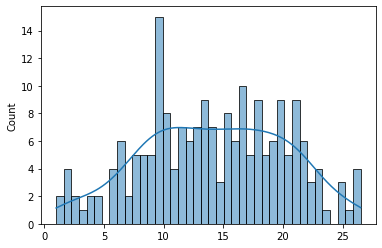

In [161]:
sns.histplot(y_holdout,bins=40,kde=True)

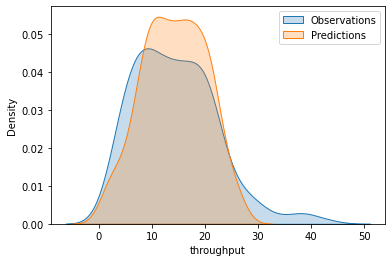

In [162]:
fig,ax = plt.subplots()

sns.kdeplot(y_test, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_holdout, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

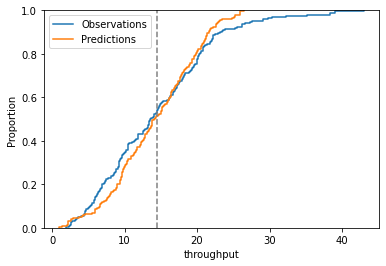

In [163]:
fig,ax = plt.subplots()

sns.ecdfplot(y_test, ax=ax, label='Observations')
sns.ecdfplot(y_holdout, ax=ax,label='Predictions')
plt.axvline(x=y_test.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [164]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test,y_holdout)
mse = mean_squared_error(y_test,y_holdout)
rmse = np.sqrt(mse)

In [165]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ela-net-rb-no
MAE,3.265579
MSE,20.760086
RMSE,4.556324


In [166]:
# err_df.to_csv(f'./holdout-test/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [167]:
res = y_test - y_holdout
res.describe().drop('count')

mean     0.224058
std      4.562231
min    -14.767743
25%     -2.387565
50%     -0.006444
75%      2.361432
max     16.622646
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

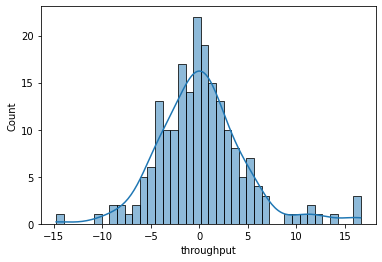

In [168]:
sns.histplot(data=res, kde=True,bins=40)

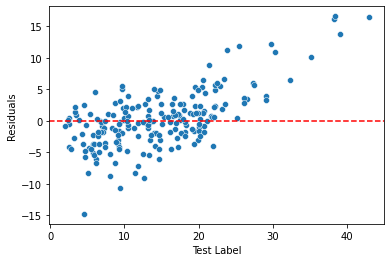

In [169]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

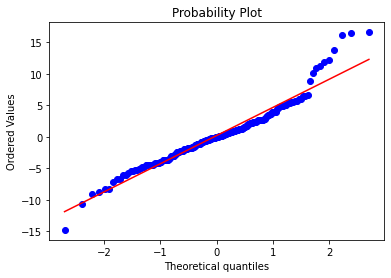

In [170]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

# Export Optimized Model

In [171]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)

RobustScaler()

In [172]:
# MODIFY! 
X = scaler.transform(X)

op_model = score_model

op_model.fit(X,y)

ElasticNet(alpha=0.003969539082438035, l1_ratio=0.7)

In [173]:
y_pred = op_model.predict(X)

<AxesSubplot:ylabel='Count'>

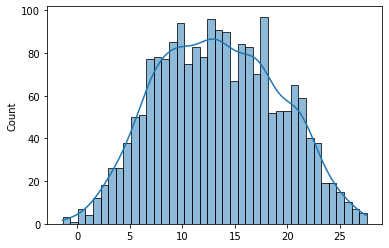

In [174]:
sns.histplot(y_pred,bins=40,kde=True)

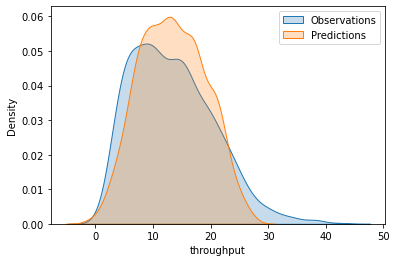

In [175]:
fig,ax = plt.subplots()

sns.kdeplot(y, ax=ax, shade=True, label='Observations')
sns.kdeplot(y_pred, ax=ax,shade=True,label='Predictions')

ax.legend(loc='best')

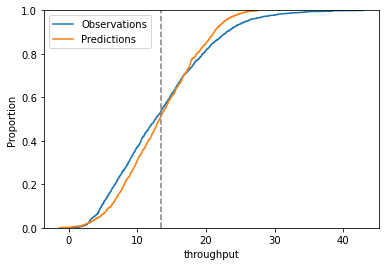

In [176]:
fig,ax = plt.subplots()

sns.ecdfplot(y, ax=ax, label='Observations')
sns.ecdfplot(y_pred, ax=ax,label='Predictions')
plt.axvline(x=y.mean(),color='grey',linestyle='--')

ax.legend(loc='best')

In [177]:
mae = mean_absolute_error(y,y_pred)
mse = mean_squared_error(y,y_pred)
rmse = np.sqrt(mse)

In [178]:
err_df = pd.DataFrame(data=[mae, mse, rmse],index=['MAE','MSE','RMSE'],columns=[f'{model_name}'])
err_df

,ela-net-rb-no
MAE,3.096296
MSE,17.457739
RMSE,4.178246


In [179]:
# err_df.to_csv(f'./model-err/{model_name}.csv')
# mean_scores.to_csv(f'./opt-model-err/{model_name}-err.csv')

In [180]:
# from joblib import dump, load
# dump(op_model, f'./opt-models/{model_name}.joblib')

In [181]:
res = y - y_pred
res.describe().drop('count')

mean   -1.879592e-15
std     4.179293e+00
min    -1.679077e+01
25%    -2.567929e+00
50%    -1.643557e-01
75%     2.263626e+00
max     3.523732e+01
Name: throughput, dtype: float64

<AxesSubplot:xlabel='throughput', ylabel='Count'>

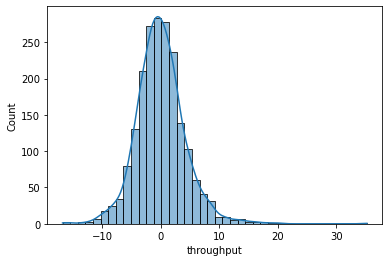

In [182]:
sns.histplot(data=res, kde=True,bins=40)

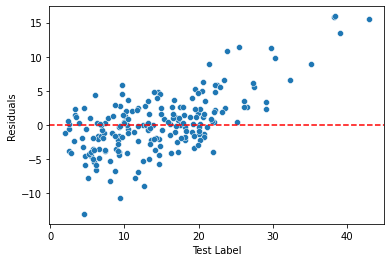

In [183]:
ax = sns.scatterplot(x=y_test, y=res)
ax.set(ylabel='Residuals', xlabel='Test Label')
plt.axhline(y=0,color='red',linestyle='--')

# there should be no clear pattern / curve in the plot
# we see a positive correlation between Test Label and Residuals -> later models should avoid this pattern

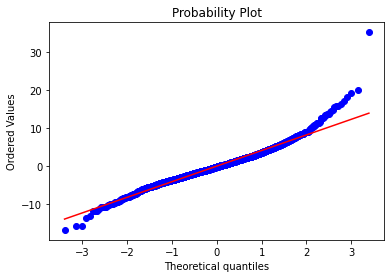

In [184]:
import scipy as sp

fig, ax = plt.subplots()
sp.stats.probplot(res,plot=ax);

DONE! 